In [2]:
# Import the necesary modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import RegexpTokenizer
from sklearn import preprocessing
from scipy.sparse import hstack
import pandas_profiling

In [3]:
# Import dataset into pandas DataFrame and remove unknown indexing column
df = pd.read_csv(r"/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")
df = df.iloc[:,1:]

# 1. Dataset Exploration

**Data Attributes**

1. ID: Unique identifier for each record
2. Title: Name of the movie
3. Year: Release year of the movie
4. Age: Target age group
5. IMDb: IMDB movie rating (/10)
6. Rotten Tomatoes: Rotten Tomatoes % rating
7. Netflix: Movie is found on netflix (1/0)
8. Hulu: Movie is found on Hulu (1/0)
9. Prime Video: Movie is found on Prime Video
10. Disney+: Movie is found on Disney+ (1/0)
11. Type: Movie or TV show
12. Directors: Name of director
13. Genres: Genre category
14. Country: Country of origin
15. Language: Original version language
16. Runtime: Duration of the movie

In [4]:
df.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,Inception,2010,13+,8.8,87%,1,0,0,0,0,Christopher Nolan,"Action,Adventure,Sci-Fi,Thriller","United States,United Kingdom","English,Japanese,French",148.0
1,2,The Matrix,1999,18+,8.7,87%,1,0,0,0,0,"Lana Wachowski,Lilly Wachowski","Action,Sci-Fi",United States,English,136.0
2,3,Avengers: Infinity War,2018,13+,8.5,84%,1,0,0,0,0,"Anthony Russo,Joe Russo","Action,Adventure,Sci-Fi",United States,English,149.0
3,4,Back to the Future,1985,7+,8.5,96%,1,0,0,0,0,Robert Zemeckis,"Adventure,Comedy,Sci-Fi",United States,English,116.0
4,5,"The Good, the Bad and the Ugly",1966,18+,8.8,97%,1,0,1,0,0,Sergio Leone,Western,"Italy,Spain,West Germany",Italian,161.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16744 entries, 0 to 16743
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               16744 non-null  int64  
 1   Title            16744 non-null  object 
 2   Year             16744 non-null  int64  
 3   Age              7354 non-null   object 
 4   IMDb             16173 non-null  float64
 5   Rotten Tomatoes  5158 non-null   object 
 6   Netflix          16744 non-null  int64  
 7   Hulu             16744 non-null  int64  
 8   Prime Video      16744 non-null  int64  
 9   Disney+          16744 non-null  int64  
 10  Type             16744 non-null  int64  
 11  Directors        16018 non-null  object 
 12  Genres           16469 non-null  object 
 13  Country          16309 non-null  object 
 14  Language         16145 non-null  object 
 15  Runtime          16152 non-null  float64
dtypes: float64(2), int64(7), object(7)
memory usage: 2.0+ MB


In [6]:
df.Type.unique()

array([0])

# 2. Handling Missing Values



In [7]:
# Find missibg values in all columns...
missing_values = pd.DataFrame(df.isnull().sum())
missing_values = missing_values.rename(columns={0:"missing_count"})
missing_values['missing_values_%'] = (missing_values.missing_count/len(df.ID))*100
missing_values

,missing_count,missing_values_%
ID,0,0.000000
Title,0,0.000000
Year,0,0.000000
Age,9390,56.079790
IMDb,571,3.410177
Rotten Tomatoes,11586,69.194935
Netflix,0,0.000000
Hulu,0,0.000000
Prime Video,0,0.000000
Disney+,0,0.000000


**Since Age and Rotten tomatoes have > 50% missing values we could:**

* Drop columns which have > 50% missing values
* Drop NA from IMDb, Directors, Genres, Country, Language, and Runtime column
* Reset index

We can also transform the year column into object type leaving it ready for plotting.

In [8]:
# Dropping values with missing % more than 50%
df.drop(['Rotten Tomatoes','Age'], axis=1, inplace=True)

# Dropping NaN's from the following columns
df.dropna(subset=['IMDb', 'Directors', 'Genres', 'Country', 'Language', 'Runtime'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Converting year into object type
df.Year = df.Year.astype('object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           15233 non-null  int64  
 1   Title        15233 non-null  object 
 2   Year         15233 non-null  object 
 3   IMDb         15233 non-null  float64
 4   Netflix      15233 non-null  int64  
 5   Hulu         15233 non-null  int64  
 6   Prime Video  15233 non-null  int64  
 7   Disney+      15233 non-null  int64  
 8   Type         15233 non-null  int64  
 9   Directors    15233 non-null  object 
 10  Genres       15233 non-null  object 
 11  Country      15233 non-null  object 
 12  Language     15233 non-null  object 
 13  Runtime      15233 non-null  float64
dtypes: float64(2), int64(6), object(6)
memory usage: 1.6+ MB


# 3. Exploratory Data Analysis


**Statistical exploration will include:**

1. Distribution plots
2. Distribution of movies on each streaming platform
3. Movie distributions according to:
    * Genre
    * Country
    * Language
4. IMDb distribution on each platform
5. Runtime analysis per platform and age group

# Year distribution:

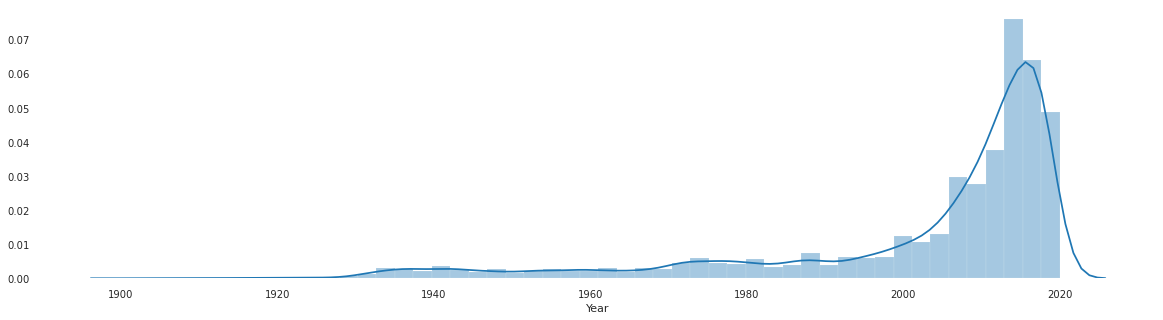

In [10]:
# Distribution of origin years
plt.figure(figsize=(20,5))
sns.distplot(df['Year'])
plt.show()

> This plot shows how most of the films catalogued in the steaming plaforms Hulu, Netflix, Prime Video and Disney+ were created/released between the years 2000 to 2020.

> **What can this tell us about the streaming platforms' target audicence?**

# IMDb ratings distribution:

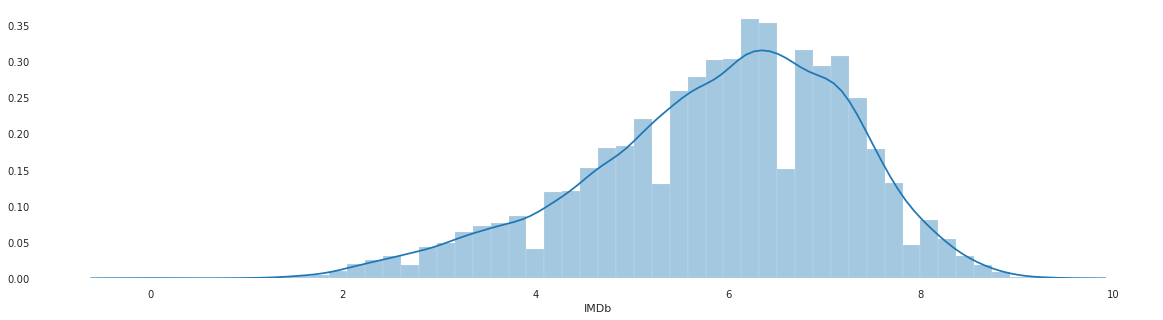

In [11]:
# Distribution of IMDb ratings
plt.figure(figsize=(20,5))
sns.distplot(df['IMDb'])
plt.show()

> The **IMDb scores distribution** is slightly negatively skewed. We can observe that the **mean** IMDb rating throughout the dataset lies around **6.5**.

# Runtime distribution:

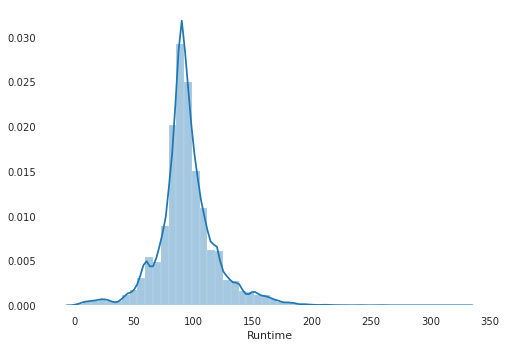

In [12]:
# Distribution of Runtime data
sns.distplot(df['Runtime'])
plt.show()

> Regarding the above **Runtime distribution** we can observe how the dataset's mean film runtime lies around **100 minutes**.

To have understand how these movies are distributed accross the different services, we can start by creating a function that counts movies for a given streaming service. We can then plot the data to understand how the films are distributed accross the platforms.

# Movies on each platform:

In [13]:
def movie_count(platform: str, count=False):
    """Calculates the number of movie per given streaming platform"""
    if count == False:
        print('Platform {} Count: {}'.format(platform, df[platform].sum()))
    else:
        return df[platform].sum()

In [14]:
# Count of movies/shows on each streaming platform
movie_count('Netflix')
movie_count('Hulu')
movie_count('Prime Video')
movie_count('Disney+')

Platform Netflix Count: 3152
Platform Hulu Count: 848
Platform Prime Video Count: 11289
Platform Disney+ Count: 542


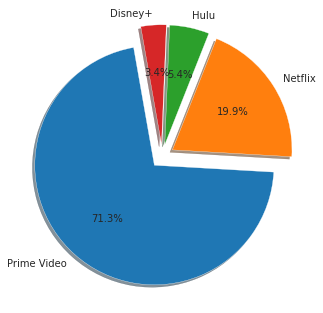

In [15]:
# Set up movies on each platform for visualisation
labels = ["Prime Video", "Netflix", "Hulu", "Disney+"]
data = [movie_count('Prime Video', count=True),
        movie_count('Netflix', count=True),
        movie_count('Hulu', count=True),
        movie_count('Disney+', count=True)]

explode = (0.1, 0.1, 0.1, 0.1)

# Plotting the data into a pie chart
fig1, ax1 = plt.subplots()
ax1.pie(data,
       labels=labels,
       autopct='%1.1f%%',
       explode=explode,
       shadow=True,
       startangle=100)

ax1.axis = ('equal')
plt.show()

> The dataset seems to contain mainly films hosted on Prime Video (71.3%) followed by Netflix (19.9%) and a similar relative percentage of movies can be found on Hulu (5.4%) and Disney+ (3.4%).

# Movie/Genre distribution:

In [16]:
# Split genres by "," and stack one after the other
genres = df['Genres'].str.split(",").apply(pd.Series, 1).stack()
genres.index = genres.index.droplevel(-1)
genres.name = "Genres"

# Delete genres column and add join new column with exsiting DataFrame
del df['Genres']
df_genres = df.join(genres)

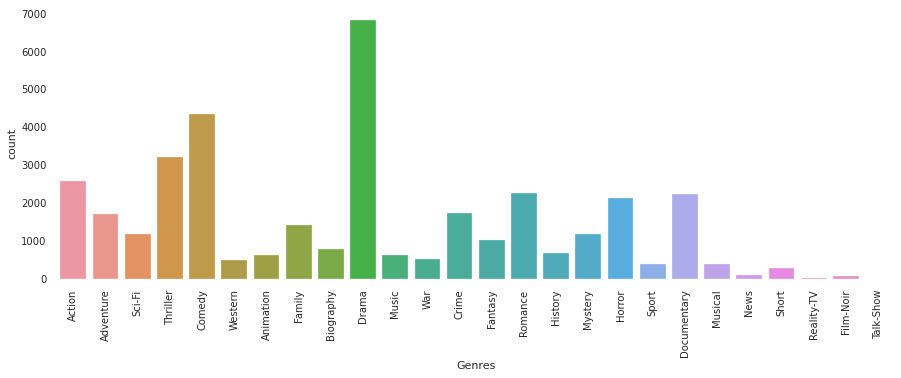

In [17]:
# Count of movies according to genre
plt.figure(figsize=(15,5))
sns.countplot(x="Genres", data=df_genres)
plt.xticks(rotation=90)
plt.show()

> It seems like most of the movies hosted by the streaming services are labeled as **dramas** and **comedies**. Nevertheless, it might also be that these are the genres that most films have in common (Comedy/Romances or Mystery/Dramas for example).

# Movie/Country distribution:

In [18]:
# Split the Country by "," and stack one after the other
countries = df['Country'].str.split(",").apply(pd.Series, 1).stack()
countries.index = countries.index.droplevel(-1)
countries.name = 'Country'

# Delete genres column and add join new column with exsiting DataFrame
del df['Country']
df_country = df.join(countries)

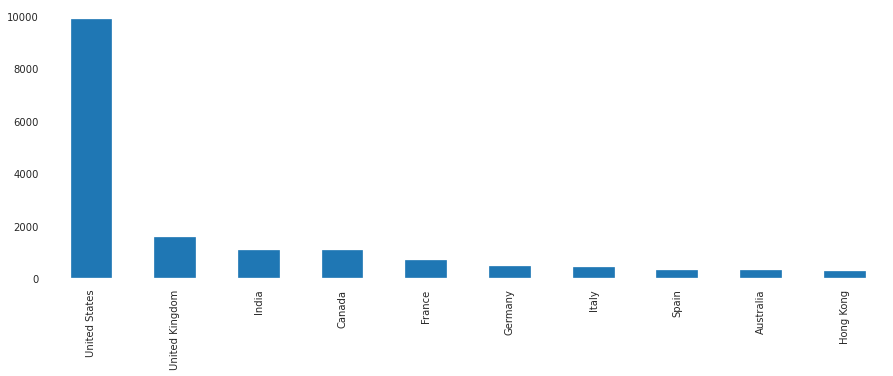

In [19]:
# Plotting top 10 countries and their respective movie count
df_country['Country'].value_counts()[:10].plot(kind='bar', figsize=(15,5))
plt.show()

> We can observe how the vast majority of films contained in the extracted catalogues were made in the United States.

# Movie/Language distribution:

In [20]:
# Perform stacking operation on language column
languages = df['Language'].str.split(',').apply(pd.Series, 1).stack()
languages.index = languages.index.droplevel(-1)
languages.name = "Language"

# Substitute new column into existing DataFrame
del df['Language']
df_language = df.join(languages)

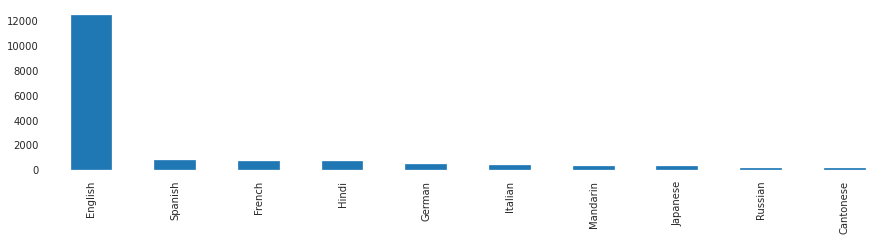

In [21]:
# Plotting top 10 languages and movie count
df_language['Language'].value_counts()[:10].plot(kind='bar', figsize=(15,3))
plt.show()

> As expected, most of the content that the 4 streaming services include in their catalogue is in English.

# IMDb-Rating/Platform distribution:

In [22]:
# Melting platform columns to create visualisation
df2 = pd.melt(df, id_vars=["ID", "Title", "Year", "IMDb", "Type", "Runtime"], var_name="platform")
df2 = df2[df2.value==1]
df2.drop(columns=["value"], axis=1, inplace=True)

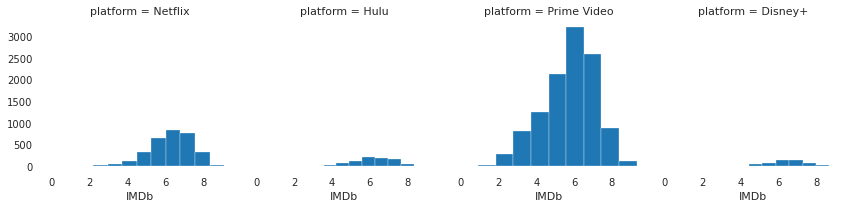

In [23]:
# Distribution of IMDb rating in different platforms
rating_platform = sns.FacetGrid(df2, col="platform")
rating_platform.map(plt.hist, "IMDb")
plt.show()

> It is easier to distinguis this distributions in platforms like Prime Video since the dataset contains 11289 movies hosted by this service. Overall, ratings tend to peak around the **6-6.5 points** for all these platforms. Prime Video's catalogue seems to have quite a few low rating movies (Not to blame, it must be unevitable when you have such a huge list of movies to offer on demand).

# Runtime/Platform/Age-Group distribution:


Since I previously had to drop the Age column due to the high number of NaN values it contained, I will start by re-loading the dataset csv file.

In [24]:
# Load dataset
df = pd.read_csv(r"/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")
df = df.iloc[:,1:]
df.ID = df.ID.astype("object")

# Melting platform columns (from wide to long) to create visualisations
df2 = pd.melt(df, id_vars=['ID','Title','Year','Age','IMDb',"Rotten Tomatoes","Type", "Runtime"], var_name="platform")
df2 = df2[df2.value==1]
df2.drop(columns=['value'], axis=1, inplace=True)

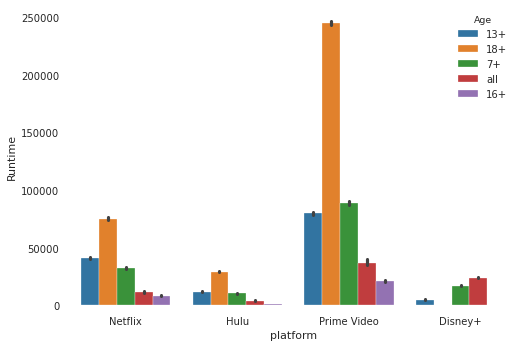

In [25]:
# Plotting total runtime across the different platforms in terms of age groups
ax = sns.barplot(x="platform", y="Runtime", hue="Age", estimator=sum, data=df2)

> This is an interesting plot. We make a few notes out of this plot:
> * Prime Video seems to be king in 18+ content
> * Hulu's main target segment also seems to be aged 18+    
> * Even though Netflix also peaks at the 18+, it provides quite a lot of content for the younger 13+ audiences
> * Disney+ provides content for the younger and all audiences

# 4. Recommendations Systems

There are three main methods used to build recommendation systems:

* **Content-Based Methods**: Define a model for users and items it interacted with. Recommends the user similar items based on item features.
* **Collaborative Filtering Methods**: Can filter out items that a user might like on the basis of reactions by similar users.
* **Hybrid Methods**: Use both content adn collaborative methods to achieve a better result.

# Step 1: Reload

In [38]:
# Reading data once again to reset changes
df = pd.read_csv(r"/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")
df = df.iloc[:,1:]

# Finding missing values in all columns
missing_values = pd.DataFrame(df.isnull().sum())
missing_values = missing_values.rename(columns={0:"missing_count"})
missing_values["missing_%"] = (missing_values.missing_count/len(df.ID))*100

# Dropping values with missing % >50%
df.drop(['Rotten Tomatoes', 'Age'], axis=1, inplace=True)

# Dropping NaN values from the following columns
df.dropna(subset=['IMDb', 'Directors', 'Genres', 'Country', 'Language', 'Runtime'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Convert to object type
df.ID = df.ID.astype('object')
df.Year = df.Year.astype('object')

# Step 2: Numerical System

This model will use cosine similarity to make recommendations.

# Preprocessing

In [28]:
# Select the numerical variable
num_df = df.select_dtypes(include=['float64', 'int64'])

In [29]:
# Scaling the numerical variable using a min-max scaler to reduce model complexity and training time
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
trans_df = pd.DataFrame((scaler.fit_transform(num_df)))
trans_df.columns = num_df.columns
trans_df.head()

,IMDb,Netflix,Hulu,Prime Video,Disney+,Type,Runtime
0,0.946237,1.0,0.0,0.0,0.0,0.0,0.449541
1,0.935484,1.0,0.0,0.0,0.0,0.0,0.412844
2,0.913978,1.0,0.0,0.0,0.0,0.0,0.452599
3,0.913978,1.0,0.0,0.0,0.0,0.0,0.351682
4,0.946237,1.0,0.0,1.0,0.0,0.0,0.489297


In [30]:
# Compute cosine similarity
cos_sim = cosine_similarity(trans_df, trans_df)

# Reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()
indices.head()

Title
Inception                         0
The Matrix                        1
Avengers: Infinity War            2
Back to the Future                3
The Good, the Bad and the Ugly    4
dtype: int64

# Recommendation Function

* The function takes 2 arguments: movie title, similarity score.
* Searches the index of the title corresponding to the original_titles index in out series of indices.
* Gets the pairwise similarity scores of all the movies.
* Sorts the similarity scores in descending order and converts them into a list.
* Returns the top 10 movie titles from the dataset.

In [31]:
def give_recommendation(title, sig=cos_sim):
    """Takes a movie title and similarity score and returns a top 10 list of 
    recommended movies from the dataset"""
    
    # Get index corresponding to the original title
    idx = indices[title]
    
    # Get the pairwise similarity scores
    sig_scores = [*enumerate(sig[idx])]
    
    # Sort the movies
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    # Scores of the 10 most similar movies
    sig_scores = sig_scores[1:11]
    
    # Movie indices
    movie_indices = [i[0] for i in sig_scores]
    
    # Top 10 similar movies
    return df['Title'].iloc[movie_indices]
    

In [32]:
give_recommendation("The Matrix", sig=cos_sim)

1269    Eh Janam Tumhare Lekhe
747          Khosla Ka Ghosla!
167                 Article 15
0                    Inception
2388                    Kaakan
1312     Merku Thodarchi Malai
742                      Udaan
57              A Silent Voice
606           Paan Singh Tomar
1528            Love Ni Bhavai
Name: Title, dtype: object

> The result seems to be pretty poor since it is only based on movie ratings, runtimes and platform variables. This can be improved by using the other qualitative variables.

# Step 3: Numerical & Textual System

This model will convert text columns into a single column and then use TF-IDF Vectorizer to create a sparse matrix of all the words TF-IDF score. Then the scaled quantitative variables will be added to the sparse matrix.

In [39]:
# Reading data once again to reset changes
df = pd.read_csv(r"/kaggle/input/movies-on-netflix-prime-video-hulu-and-disney/MoviesOnStreamingPlatforms_updated.csv")
df = df.iloc[:,1:]

# Finding missing values in all columns
missing_values = pd.DataFrame(df.isnull().sum())
missing_values = missing_values.rename(columns={0:"missing_count"})
missing_values["missing_%"] = (missing_values.missing_count/len(df.ID))*100

# Dropping values with missing % >50%
df.drop(['Rotten Tomatoes', 'Age'], axis=1, inplace=True)

# Dropping NaN values from the following columns
df.dropna(subset=['IMDb', 'Directors', 'Genres', 'Country', 'Language', 'Runtime'], inplace=True)
df.reset_index(inplace=True, drop=True)

# Convert to object type
df.ID = df.ID.astype('object')
df.Year = df.Year.astype('object')

# Preprocessing

* Selecting all object data types and storing them in a list.
* Removing ID and Title column.
* Joining all text/object columns using commas into a single column.
* Creating a tokenizer to remove unwanted elements from the data like symbols and numbers.
* Converting TfidfVector from the text after quant columns preprocessing.
* Inserting quant variables into a DataFrame.
* Scaling quant using MixMaxScaler range(0,1).
* Adding quant variables in the TF-IDF vectors sparse matrix using hstack function (add horizontal arrays into a sparse matrix).

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15233 entries, 0 to 15232
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ID           15233 non-null  object 
 1   Title        15233 non-null  object 
 2   Year         15233 non-null  object 
 3   IMDb         15233 non-null  float64
 4   Netflix      15233 non-null  int64  
 5   Hulu         15233 non-null  int64  
 6   Prime Video  15233 non-null  int64  
 7   Disney+      15233 non-null  int64  
 8   Type         15233 non-null  int64  
 9   Directors    15233 non-null  object 
 10  Genres       15233 non-null  object 
 11  Country      15233 non-null  object 
 12  Language     15233 non-null  object 
 13  Runtime      15233 non-null  float64
dtypes: float64(2), int64(5), object(7)
memory usage: 1.6+ MB


In [49]:
def preprocess(df):
    """Conducts preprocessing process detailed above over the input DataFrame"""
    
    # Store all object columns in a list
    objects = list(df.select_dtypes(include=['object']).columns)
    
    # Removing ID and Title column
    objects.remove("Title")
    objects.remove('ID')
    
    # Joining all text/object columns delimited by comma
    df['all_text'] = df[objects].apply(lambda x: ",".join(x.dropna().astype(str)), axis=1)
    
    # Create tokenizer to remove unwanted elements from data (symbols, numbers...)
    token = RegexpTokenizer(r'[a-zA-Z]+')
    
    # Convert TfidfVector from text
    cv = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1,1), tokenizer=token.tokenize)
    text_counts = cv.fit_transform(df['all_text'])
    
    # Select quantitative variables and scale them
    num_df = df.select_dtypes(include=['float64', 'int64'])
    scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaled_num_df = pd.DataFrame(scaler.fit_transform(num_df))
    scaled_num_df.columns = num_df.columns
    
    # Add quantitative variables to the TF-IDF vector
    IMDb = scaled_num_df.IMDb.values[:,None]
    X_train_dtm = hstack((text_counts, IMDb))
    Netflix = scaled_num_df.Netflix.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Netflix))
    Hulu = scaled_num_df.Hulu.values[:, None]
    X_train_dtm = hstack((X_train_dtm, Hulu))
    Prime = scaled_num_df["Prime Video"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Prime))
    Disney = scaled_num_df["Disney+"].values[:, None]
    X_train_dtm = hstack((X_train_dtm, Disney))
    Runtime = scaled_num_df['Runtime'].values[:, None]
    
    return X_train_dtm

In [50]:
# Preprocessing data
mat = preprocess(df)
mat.shape

(15233, 11996)

# Improved recommendations:

In [52]:
# Compute the sigmoid kernel
sig2 = cosine_similarity(mat, mat)

# Reverse mapping of indices and movie titles
indices = pd.Series(df.index, index=df['Title']).drop_duplicates()

# Getting a recommendation
give_recommendation("The Matrix", sig=sig2)

81             The Matrix Reloaded
245         The Matrix Revolutions
755              Jupiter Ascending
154                 Miss Americana
0                        Inception
3               Back to the Future
1971    The Girl Allergic to Wi-Fi
53      Back to the Future Part II
36                 Minority Report
132        Solo: A Star Wars Story
Name: Title, dtype: object

> This model clearly produces a higher quality result with films that are pretty similar to "The Matrix". Adding more relevant data like descriptive text, content-based recommendations systems can improve their performance.